# Computing centralities from OS Open data

Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

## Data Source

The following example uses the [OS Open Roads](https://osdatahub.os.uk/downloads/open/OpenRoads) dataset, which is available under the [Open Government License](http://os.uk/opendata/licence).


## Preparation

The following example assumes:
- That the notebook is being run from a cloned `cityseer-api` repository.
- That the above dataset has been downloaded to `temp/os_open_roads/oproad_gb.gpkg` as a relative path. If running this notebook directly from within a clone of the `cityseer-api` repo, then this equates to the `cityseer-api/temp/os_open_roads/oproad_gb.gpkg` path. Please edit the paths and path setup in this cell if you are using different directories.


In [2]:
from pathlib import Path

repo_path = Path.cwd()
if str(repo_path).endswith("centrality"):
    repo_path = Path.cwd() / "../.."
if not str(repo_path.resolve()).endswith("cityseer-api"):
    raise ValueError("Please check your notebook working directory relative to your project and data paths.")

open_roads_path = Path(repo_path / "temp/os_open_roads/oproad_gb.gpkg")
print("data path:", open_roads_path)
print("path exists:", open_roads_path.exists())

data path: /Users/gareth/dev/benchmark-urbanism/cityseer-api/demos/centrality/../../temp/os_open_roads/oproad_gb.gpkg
path exists: True


## Extents

Instead of loading the entire dataset, we'll use a bounding box to only load an area of interest.

In [3]:
from pyproj import Transformer
from shapely import geometry

from cityseer.tools import graphs, io

# bbox setup
lng, lat = -0.13396079424572427, 51.51371088849723
buffer_dist = 5000
plot_buffer = 3500
# transform from WGS to BNG
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700")
easting, northing = transformer.transform(lat, lng)
# calculate bbox relative to centroid
centroid = geometry.Point(easting, northing)
target_bbox: tuple[float, float, float, float] = centroid.buffer(buffer_dist).bounds  # type: ignore
plot_bbox: tuple[float, float, float, float] = centroid.buffer(plot_buffer).bounds  # type: ignore

## Load

We can now load the OS Open Roads dataset and convert it to a format that can be used by cityseer for downstream calculations.

In [4]:
# load OS Open Roads data from downloaded geopackage
G_open = io.nx_from_open_roads(open_roads_path, target_bbox=target_bbox)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G_open, 25)
# prepare the data structures
nodes_gdf, network_structure = graphs.network_structure_from_nx(G_decomp, crs=27700)

INFO:cityseer.tools.io:Nodes: 18160
INFO:cityseer.tools.io:Edges: 24160
INFO:cityseer.tools.io:Dropped 431 edges where not both start and end nodes were present.
INFO:cityseer.tools.io:Running basic graph cleaning
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 18160/18160 [00:00<00:00, 37999.03it/s]
INFO:cityseer.tools.graphs:Merging parallel edges within buffer of 10.
100%|██████████| 22563/22563 [00:00<00:00, 121360.67it/s]
INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 25.
100%|██████████| 22504/22504 [00:12<00:00, 1825.26it/s]
INFO:cityseer.tools.graphs:Preparing node and edge arrays from networkX graph.
100%|██████████| 75792/75792 [00:11<00:00, 6408.82it/s]


## Calculate centralities

The centrality methods can now be computed.

In [5]:
from cityseer.metrics import networks

# this will take around 3-5 minutes depending on the available resources
# if you want to compute wider area centralities, e.g. 20km, then use less decomposition to speed up the computation
nodes_gdf = networks.node_centrality(
    measures=["node_beta", "node_betweenness"],
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=[250, 500, 2000],
)

INFO:cityseer.metrics.networks:Computing node_beta, node_betweenness centrality measures using shortest (non-angular) path heuristic.


100%|██████████| 75792.0/75792 [10:32<00:00, 119.79it/s]


## Plots

Let's plot a selection of distance thresholds for each of the computed measures.


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 87.57m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


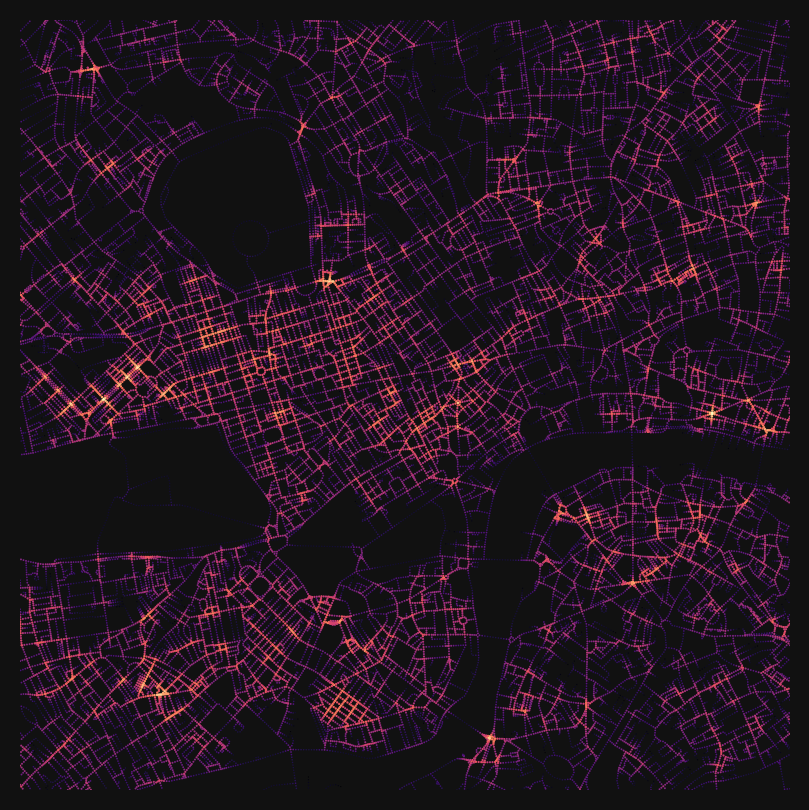


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 175.37m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


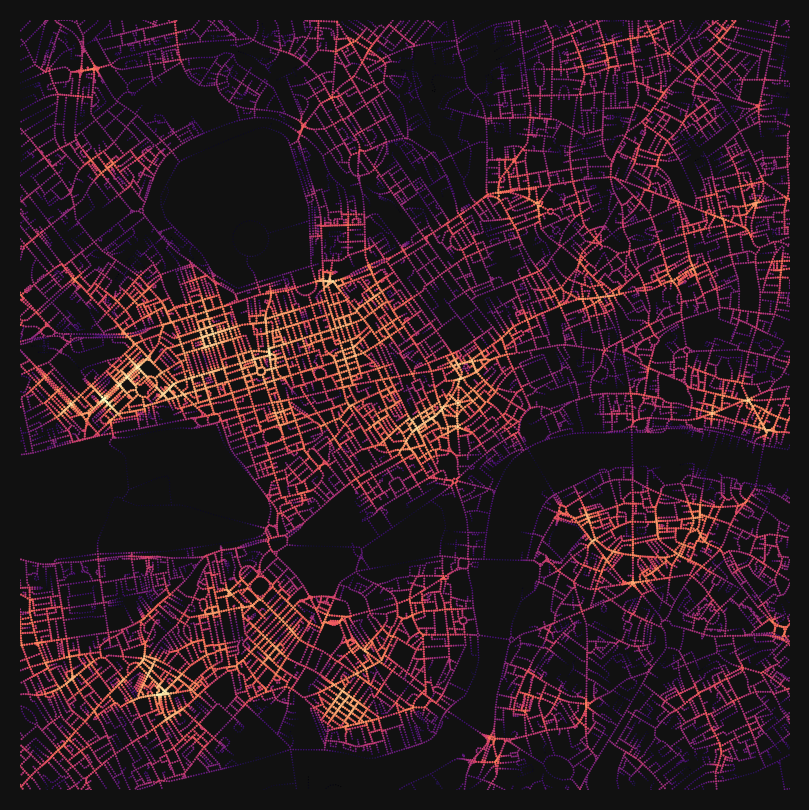


    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


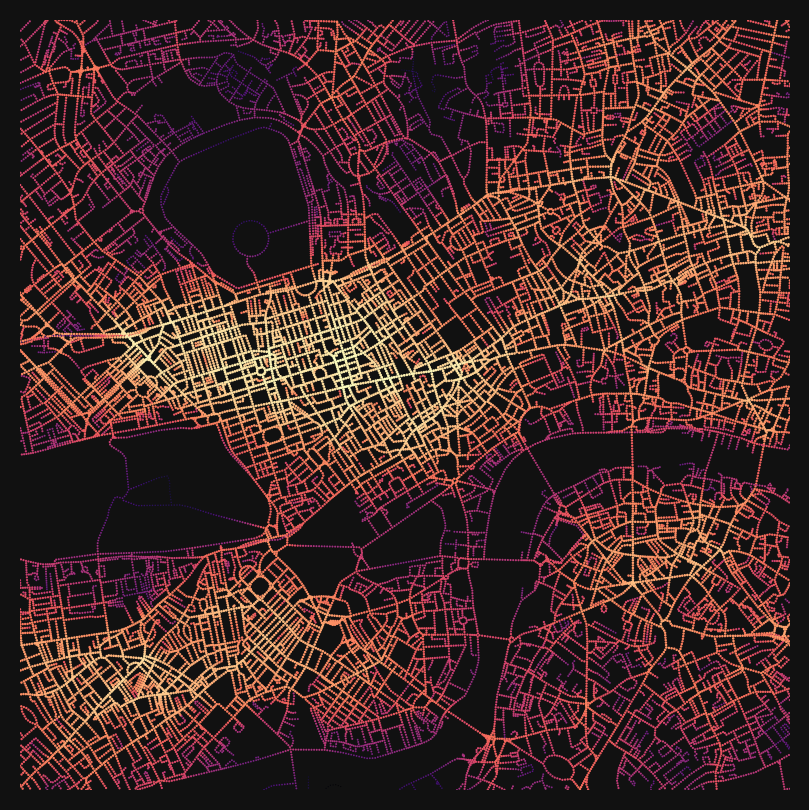


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 87.57m
    Beta: 0.016 (spatial impedance factor)
    Max walking tolerance: 250.0m
    


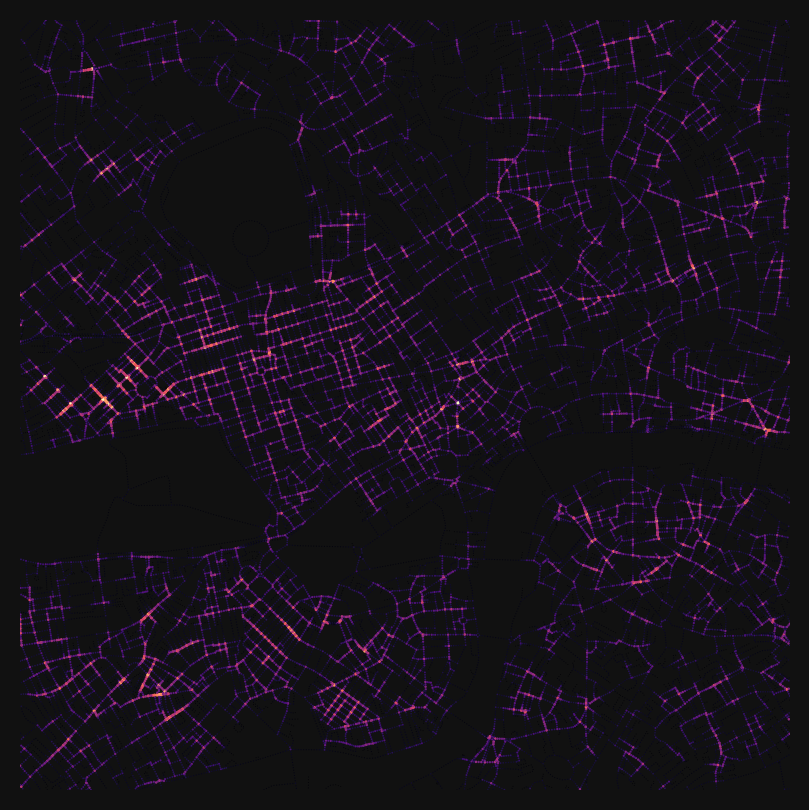


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 175.37m
    Beta: 0.008 (spatial impedance factor)
    Max walking tolerance: 500.0m
    


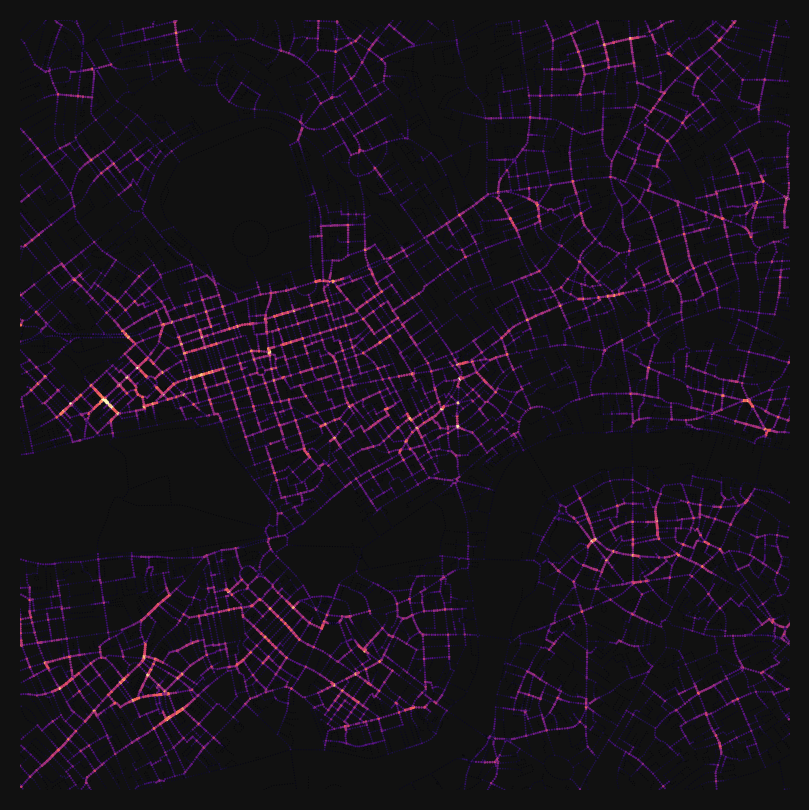


    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: 702.16m
    Beta: 0.002 (spatial impedance factor)
    Max walking tolerance: 2000.0m
    


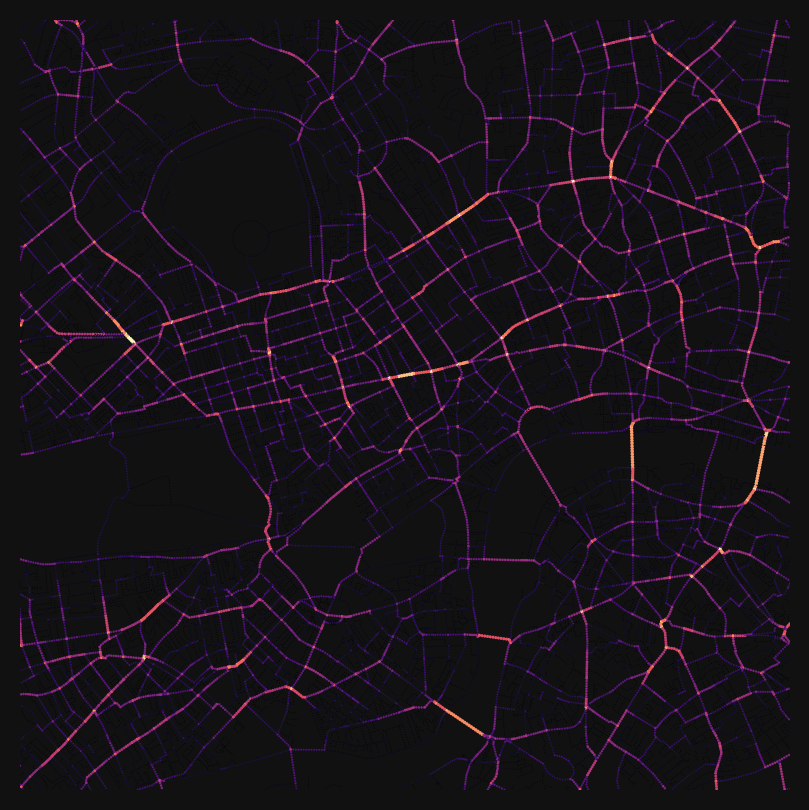

In [6]:
import matplotlib.pyplot as plt
from cityseer.tools import plot

bg_colour = "#111"
for d in [250, 500, 2000]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    "Gravity" index / spatial impedance weighted (closeness-like) centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        ax,
        network_structure.nodes.xs,
        network_structure.nodes.ys,
        nodes_gdf[f"cc_metric_node_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    plt.show()

for d in [250, 500, 2000]:
    b = networks.beta_from_distance(d)[0]
    avg_d = networks.avg_distance_for_beta(float(b))[0]
    print(
        f"""
    Spatial impedance weighted betweenness centrality:
    Avg walking tolerance: {avg_d:.2f}m
    Beta: {b:.3f} (spatial impedance factor)
    Max walking tolerance: {d:.1f}m
    """
    )
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200, facecolor=bg_colour)
    plot.plot_scatter(
        ax,
        network_structure.nodes.xs,
        network_structure.nodes.ys,
        nodes_gdf[f"cc_metric_node_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    plt.show()